# Routing travel time validation (gtfs2nx vs. Google Maps)

## Create routable networkx graph from GTFS feed

In [ ]:
# Install pip package
!pip install git+https://github.com/ai4up/gtfs2nx@v0.1.0

In [2]:
# Download exemplary GTFS feeds
!wget -O gtfs-toulouse-example.zip https://data.toulouse-metropole.fr/api/v2/catalog/datasets/tisseo-gtfs/files/fc1dda89077cf37e4f7521760e0ef4e9

--2023-10-04 12:24:51--  https://data.toulouse-metropole.fr/api/v2/catalog/datasets/tisseo-gtfs/files/fc1dda89077cf37e4f7521760e0ef4e9
Resolving data.toulouse-metropole.fr (data.toulouse-metropole.fr)... 34.248.20.69, 34.249.199.226
Connecting to data.toulouse-metropole.fr (data.toulouse-metropole.fr)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘gtfs-toulouse-example.zip’

gtfs-toulouse-examp     [               <=>  ]  11.40M   933KB/s    in 55s     

2023-10-04 12:26:01 (214 KB/s) - ‘gtfs-toulouse-example.zip’ saved [11955703]



In [3]:
# Create graph

import gtfs2nx as gx

path = 'gtfs-toulouse-example.zip'
G = gx.transit_graph(path, time_window=('06:00', '10:00'))

2023-10-04 12:26:32,915 | INFO | STEP 1/5 - Loading GTFS feed(s) ...
2023-10-04 12:27:09,191 | INFO | STEP 2/5 - Preprocessing GTFS feeds ...


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2023-10-04 12:27:13,315 | INFO |            Filtering transit service between 06:00 and 10:00...
2023-10-04 12:28:22,624 | INFO | STEP 3/5 - Determining service frequency, transfer waiting & travel times...
2023-10-04 12:31:41,832 | INFO | STEP 4/5 - Creating NetworkX graph...
2023-10-04 12:31:42,055 | INFO | STEP 5/5 - Adding edges for walk transfers between stops no more than 200 m apart (assuming walk speed of 4 km/h)...


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: title={'center': 'frequency'}>

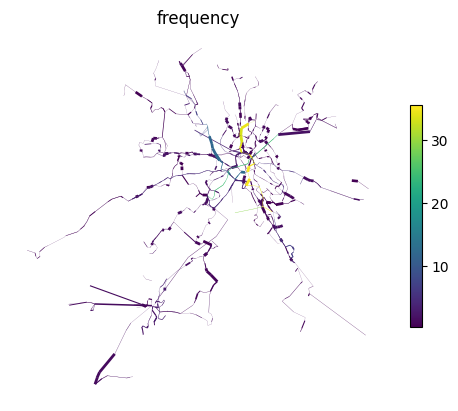

In [13]:
# Visualize graph and extracted frequencies

from gtfs2nx import utils

utils.plot_network(G, 'frequency')

## Routing time comparison

In [4]:
import googlemaps

# TODO replace with your API key from https://console.cloud.google.com/google/maps-apis/credentials
API_KEY = 'YOUR_API_KEY'
gmaps = googlemaps.Client(key=API_KEY)

2023-10-04 12:31:50,199 | INFO | API queries_quota: 60


##### Calculate travel times for 50 exemplary destinations

In [19]:
import datetime

import networkx as nx
import pandas as pd

def gmaps_travel_time(client, origin, destination):
    now = datetime.datetime.now()
    distance_details = client.distance_matrix(origins=[(origin.y, origin.x)], destinations=[(destination.y, destination.x)], mode='transit', departure_time=now)
    travel_time = distance_details['rows'][0]['elements'][0]['duration']['value']
    return travel_time


def nx_travel_time(G, origin, destination):
    try:
        return nx.shortest_path_length(G, origin, destination, weight='weight')
    except nx.NetworkXNoPath:
        print(f'No path between {origin} and {destination}.')
        return None


nodes = utils.nodes_to_gdf(G).to_crs('EPSG:4326')

# compare travel times only for stops with relatively high frequency
# (otherwise the comparison will be skewed because Google Maps does not enforce that transit trip start at the selected stop, but allows walking to any nearby stop)
freq_nodes = nodes[nodes['frequency'] > 5] 
origins = freq_nodes.sample(50, random_state=0)
destinations = freq_nodes.sample(50, random_state=1)

ex_routes = pd.DataFrame()
ex_routes['origin_idx'] = origins.index
ex_routes['destination_idx'] = destinations.index
ex_routes['origin'] = origins.geometry.values
ex_routes['destination'] = destinations.geometry.values
ex_routes['travel_time'] = ex_routes.apply(lambda x: gmaps_travel_time(gmaps, x['origin'], x['destination']), axis=1)
ex_routes['travel_time_nx'] = ex_routes.apply(lambda x: nx_travel_time(G, x['origin_idx'], x['destination_idx']), axis=1)
ex_routes.head(10)

,origin_idx,destination_idx,origin,destination,travel_time,travel_time_nx
0,stop_point:SP_4942@@line:68,stop_point:SP_612@@line:68,POINT (1.41165 43.60075),POINT (1.38985 43.63693),960,970.640611
1,stop_point:SP_297@@line:139,stop_point:SP_4725@@line:170,POINT (1.37846 43.62933),POINT (1.50400 43.50968),4689,NaN
2,stop_point:SP_3199@@line:139,stop_point:SP_1106@@line:68,POINT (1.37994 43.62894),POINT (1.44051 43.59224),2640,2427.533207
3,stop_point:SP_1984@@line:69,stop_point:SP_66@@line:170,POINT (1.44920 43.60603),POINT (1.50443 43.51375),2542,2143.579507
4,stop_point:SP_277@@line:170,stop_point:SP_3119@@line:68,POINT (1.48755 43.53068),POINT (1.37358 43.65493),4680,NaN
5,stop_point:SP_1831@@line:61,stop_point:SP_332@@line:69,POINT (1.39221 43.57007),POINT (1.46462 43.56808),1980,1596.377862
6,stop_point:SP_3971@@line:68,stop_point:SP_2224@@line:69,POINT (1.44050 43.59214),POINT (1.43419 43.62692),1026,1178.978406
7,stop_point:SP_3020@@line:68,stop_point:SP_375@@line:61,POINT (1.43551 43.59267),POINT (1.46318 43.61538),1174,1222.234920
8,stop_point:SP_2467@@line:176,stop_point:SP_2297@@line:69,POINT (1.39998 43.59224),POINT (1.43501 43.63361),2060,1824.686461
9,stop_point:SP_3475@@line:61,stop_point:SP_1187@@line:68,POINT (1.40187 43.57023),POINT (1.39702 43.61830),1665,2518.692795


##### Analyze travel time estimation error

/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_37206/1172311626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_routes['error'] = (ex_routes['travel_time'] - ex_routes['travel_time_nx']) / 60


MAE: 4.41 y
RMSE: 5.78 y
MAPE: 0.24 y
R2: 0.8690


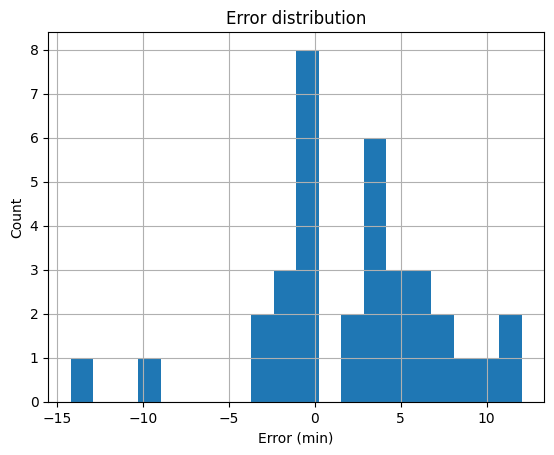

In [20]:
from sklearn import metrics
import numpy as np

ex_routes = ex_routes.dropna()
ex_routes['error'] = (ex_routes['travel_time'] - ex_routes['travel_time_nx']) / 60
ax = ex_routes['error'].hist(bins=20)
ax.set_title('Error distribution')
ax.set_xlabel('Error (min)')
ax.set_ylabel('Count')


true = ex_routes['travel_time'] / 60
est = ex_routes['travel_time_nx'] / 60

mae = metrics.mean_absolute_error(true, est)
rmse = np.sqrt(metrics.mean_squared_error(true, est))
mape = metrics.mean_absolute_percentage_error(true, est)
r2 = metrics.r2_score(true, est)

print('MAE: {:.2f} y'.format(mae))
print('RMSE: {:.2f} y'.format(rmse))
print('MAPE: {:.2f} y'.format(mape))
print('R2: {:.4f}'.format(r2))
